In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rc('font', size=12)

from numba import njit

# Voter model with mutation

In [2]:
@njit
def init_grid(L):
    '''Initialises an L by L grid with numbers drawn randomly from (0, 1)'''
    return np.random.rand(L, L)

In [3]:
@njit
def get_4_neighbors(i, j, L):
    '''Finds upper, lower, left and right neighbor of a site in a K by K grid'''
    neighbors = []
    # Up, down, right, left
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]  
    for di, dj in directions:
        # Apply periodic boundary conditions
        neighbor_i = int((i + di) % L)
        neighbor_j = int((j + dj) % L)
        neighbors.append((neighbor_i, neighbor_j))
    return neighbors

In [4]:
import random

@njit
def voter_model(grid_0, alpha, n_iters):
    '''Run experiment with the voter model
    Inputs:
    grid_0 (numpy array): Initial grid
    alpha (float): Value of alpha parameter
    n_iters (int): Number of times that the entire grid is updated
    
    Returns:
    cur_grid (numpy array): Grid after n_iter iterations
    num_species (list): Contains amount of different species at each tenth iteration
    '''
    # Create list to store number of unique species
    num_species = []
    cur_grid = np.copy(grid_0)
    
    height, width = cur_grid.shape
    xs = np.random.choice(np.arange(0, width), size=n_iters)
    ys = np.random.choice(np.arange(0, height), size=n_iters)
        
    # Update grid n_iter times
    for i in range(n_iters):
        
        if random.random() < alpha:
            cur_grid[xs[i], ys[i]] = random.random()
        # Set species in cell to that in one of its 4 neighbors with equal probability
        else:
            neighbors = get_4_neighbors(xs[i], ys[i], L)
            neighbor_idx = np.random.choice(len(neighbors))
            new_type = cur_grid[neighbors[neighbor_idx]]
            cur_grid[xs[i], ys[i]] = new_type
        # Save amount of species every tenth iteration
        if i % (n_iters//100) == 0:
            num_species.append(len(np.unique(cur_grid)))
    return cur_grid, num_species

In [5]:
# Define parameters as in paper
alpha = 10e-5
L = 150

grid_0 = init_grid(L)
n_iters = int(10e7)

print(n_iters)
grid, num_species = voter_model(grid_0, alpha, n_iters)

100000000


Text(0.5, 1.0, 'Grid after 100000000 iterations')

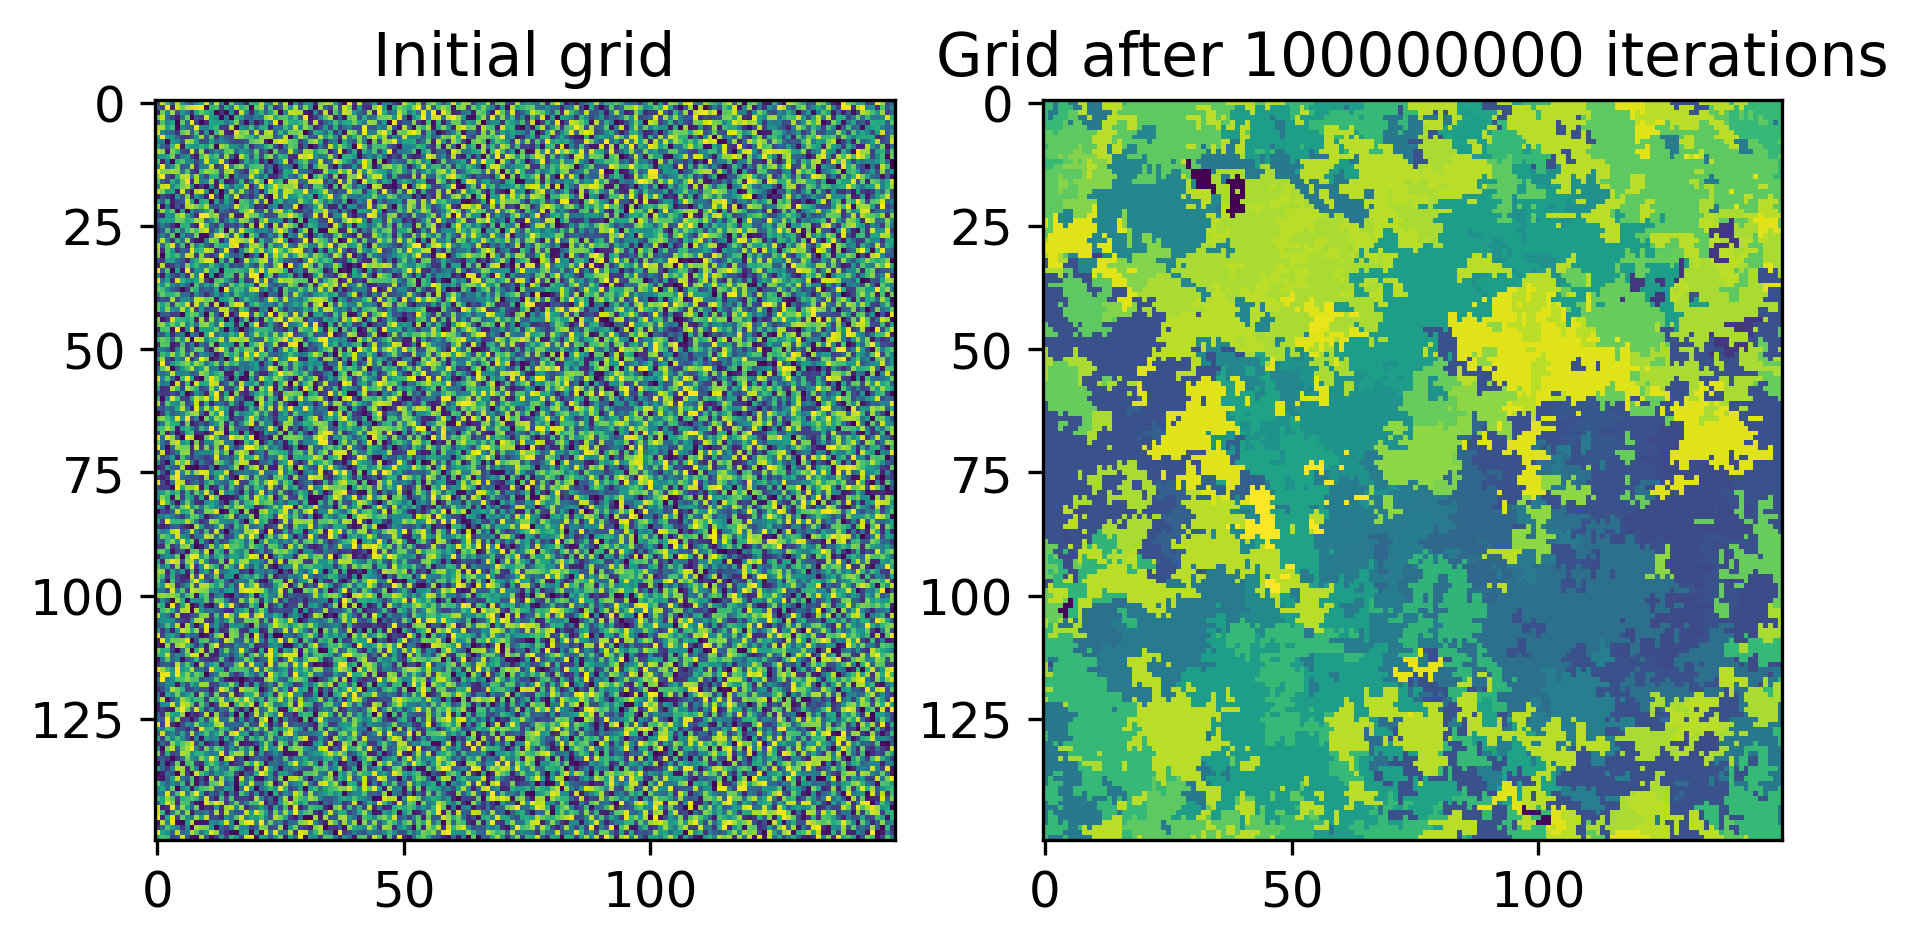

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7))

ax1.imshow(grid_0)
ax1.set_title('Initial grid')

ax2.imshow(grid)
ax2.set_title(f'Grid after {n_iters} iterations')



Text(0.5, 0, 'Number of iterations (x10)')

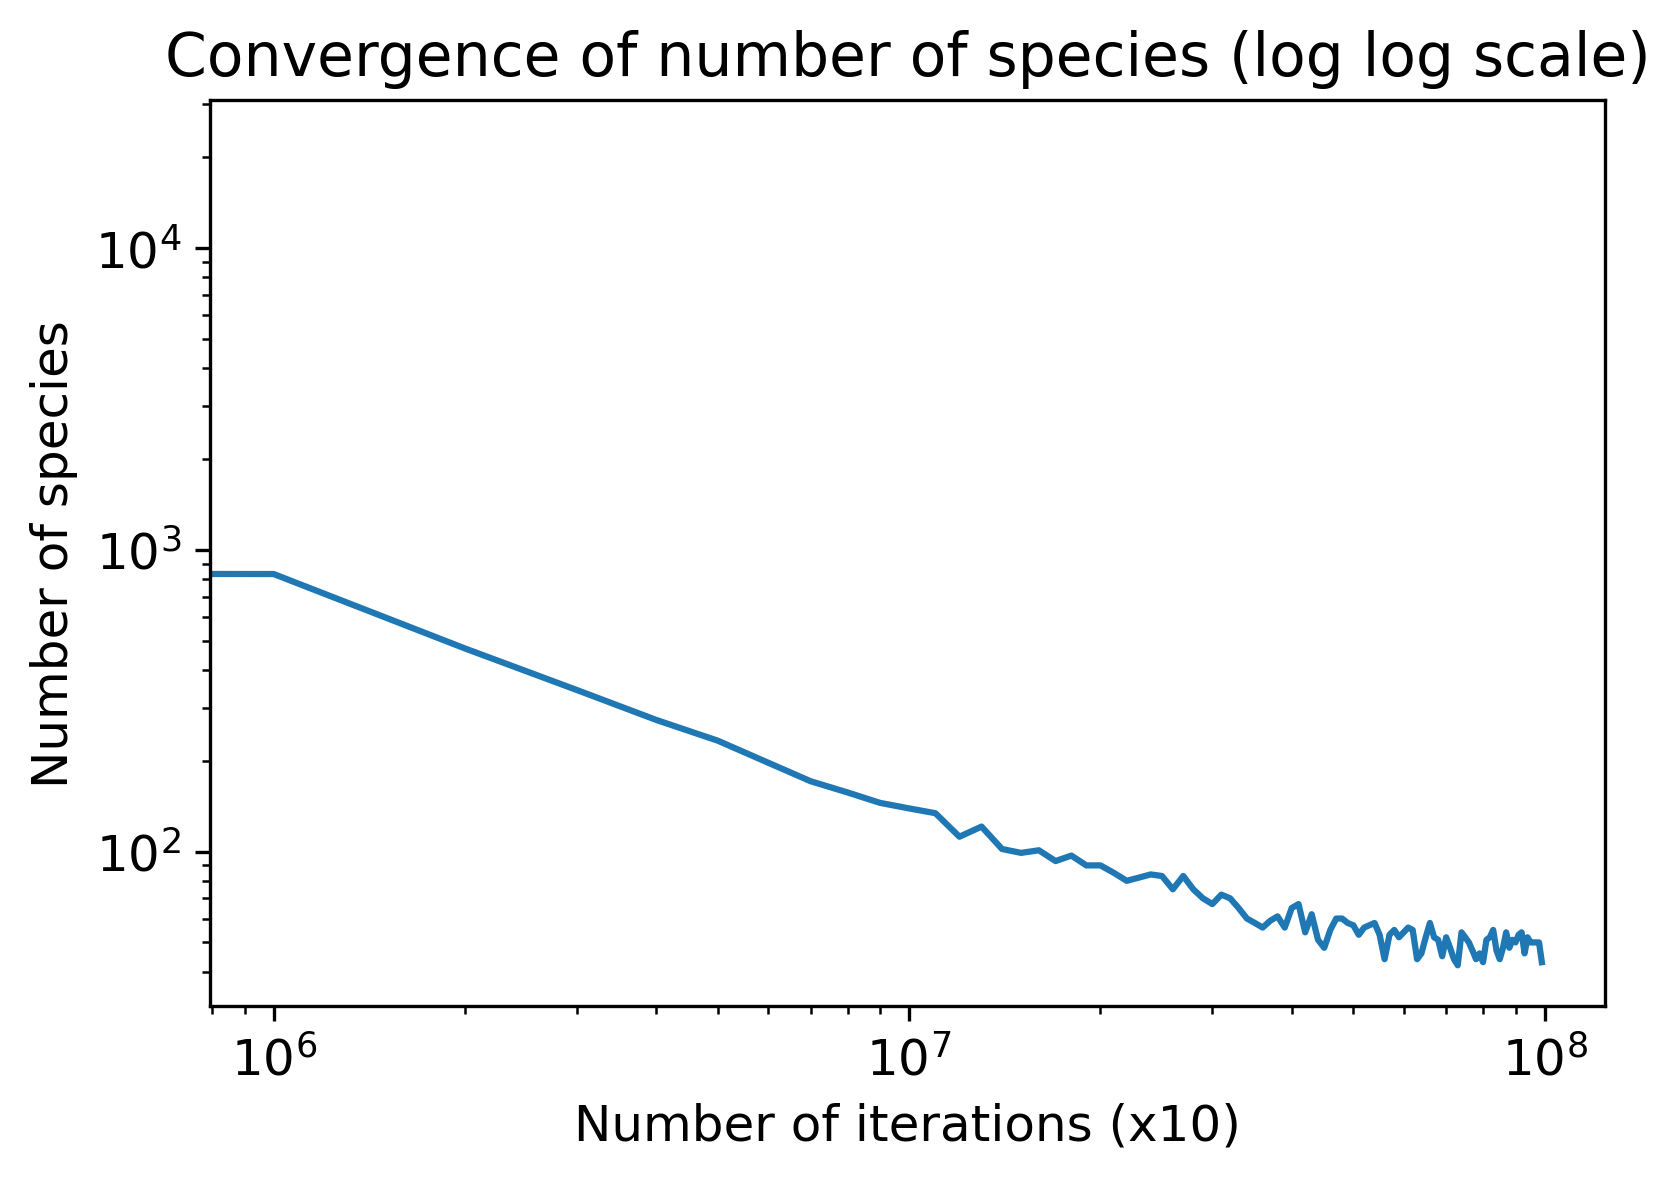

In [7]:
plt.loglog(np.arange(0, n_iters, n_iters/100), num_species)
plt.title('Convergence of number of species (log log scale)')
plt.ylabel('Number of species')
plt.xlabel('Number of iterations (x10)')

In [8]:
def sa_curve(grid):
    height, width = grid.shape
    
    n_centers = 10
    centers_x = np.random.choice(np.arange(0, width), n_centers) + width
    centers_y = np.random.choice(np.arange(0, height), n_centers) + height

    areas = []
    species = []
    
    torus_grid = np.vstack((grid, grid, grid))
    torus_grid = np.hstack((torus_grid, torus_grid, torus_grid))
    
    torus_grid.shape
    
    for i, (x, y) in enumerate(zip(centers_x, centers_y)):
        cur_species = []
        for j in range(width//2):
            cur_species.append(len(np.unique(torus_grid[x-j:x+j+1, y-j:y+j+1])))
            if i == 0:
                areas.append((j+1)**2)
        species.append(cur_species)
    
    return areas, species

In [9]:
areas, species = sa_curve(grid)

[ 0.44678305 -0.05782634]


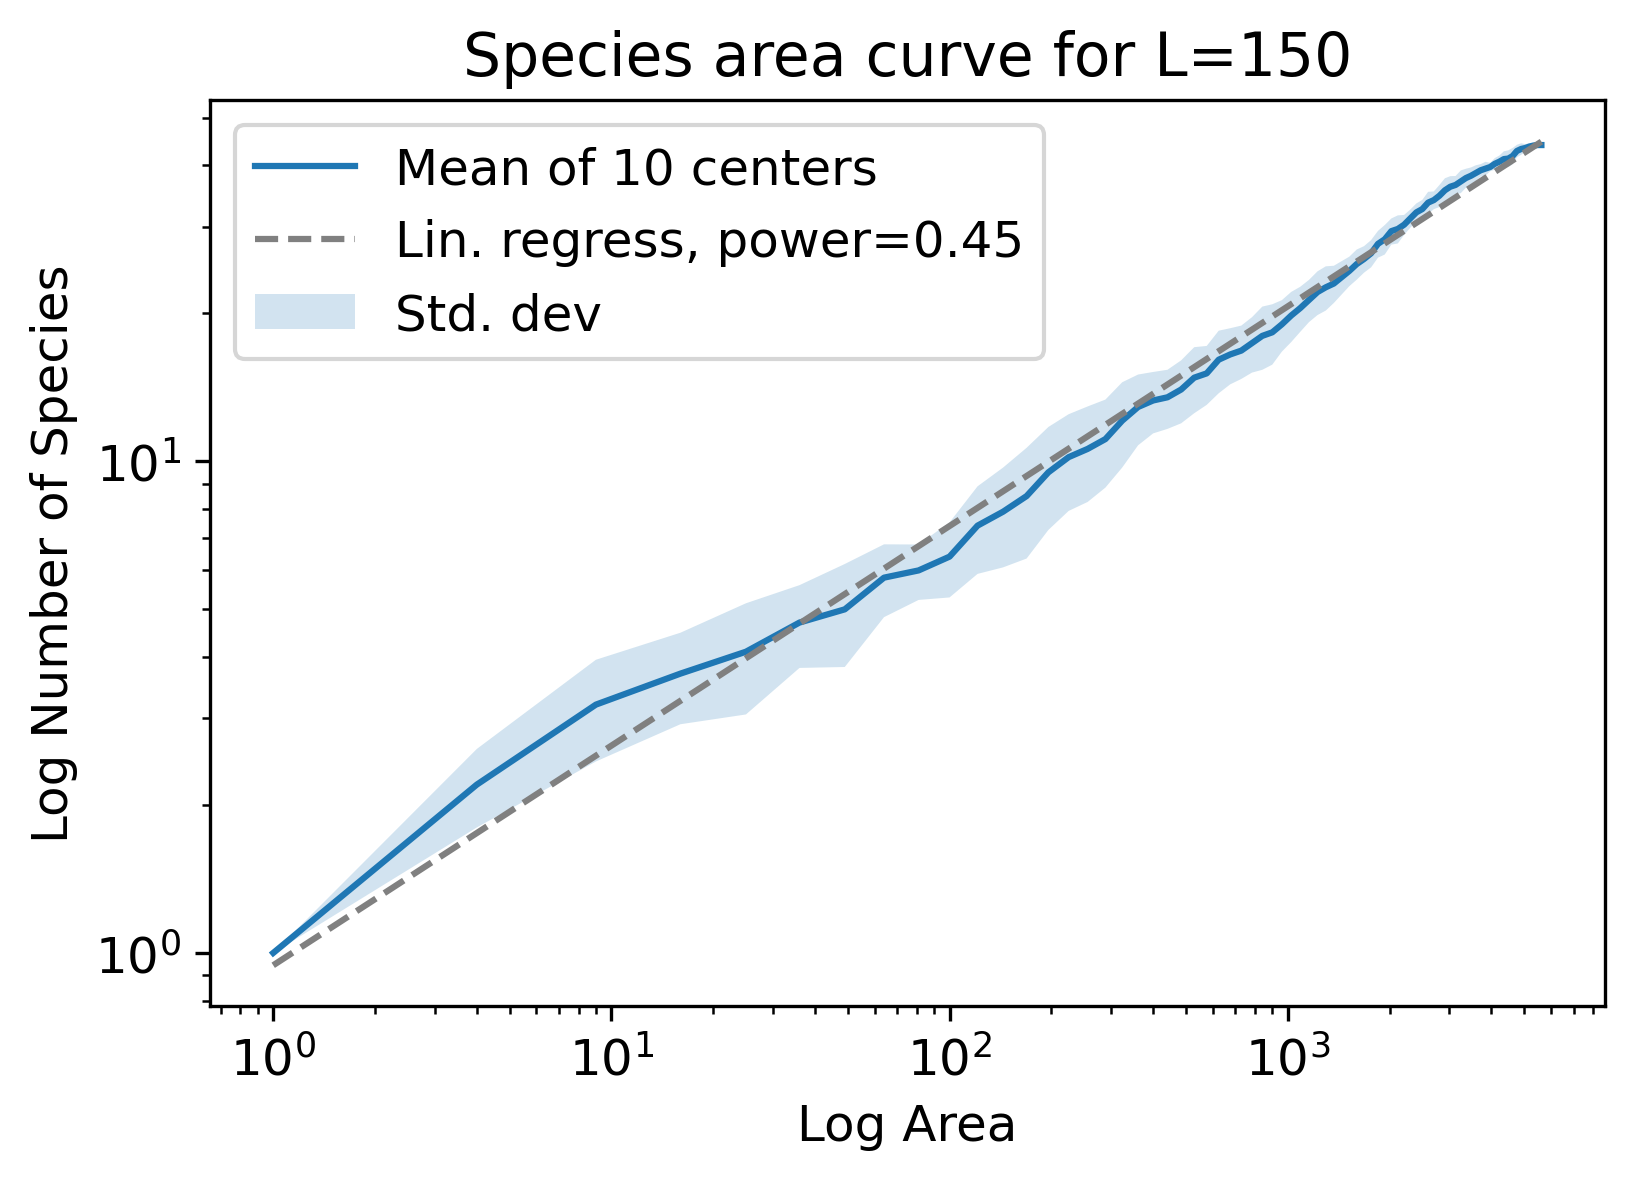

In [10]:
spec_std_dev = np.std(species, axis=0)
spec_mean = np.mean(species, axis=0)

poly_coeffs = np.polyfit(np.log(areas), np.log(spec_mean), 1)
print(poly_coeffs)

plt.loglog(areas, spec_mean, label='Mean of 10 centers')
plt.loglog([areas[0], areas[-1]], 
           np.exp(poly_coeffs[1]) * np.array([areas[0], areas[-1]])**poly_coeffs[0], 
           color='grey', 
           linestyle='dashed',
           label=f'Lin. regress, power={round(poly_coeffs[0], 2)}')
plt.fill_between(areas, spec_mean-spec_std_dev, spec_mean+spec_std_dev, alpha=0.2, label='Std. dev')
plt.ylabel('Log Number of Species')
plt.xlabel('Log Area')
plt.title(f'Species area curve for L={L}')
plt.legend()
plt.show()